# Project (Assignment 3): Unsupervised Learning (E-Commerce Orders)

This notebook is your working template for **Assignment 3**.

**Note:** This assessment comprises two parts: question-guided processing/modeling (Unsupervised learning) and free-form exploration.

**Total Marks: 20**

You will:

- Continue working with the expanded dataset from Assignment 1
- Perform **clustering** to identify similar order types
- Apply **market basket analysis** (association rule mining)
- Write up findings throughout the notebook
- Publish your analysis as a github.io page

Work **top-to-bottom**. Complete each task in order before moving on.


## Setup

Run the cell below to import the required Python packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

plt.style.use('seaborn-v0_8')

# Suppress DeprecationWarning from jupyter_client
warnings.filterwarnings("ignore", category=DeprecationWarning, module='jupyter_client')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

## Load Your Cleaned Dataset from Assignment 1

Load the cleaned and expanded dataset you created in Assignment 1 (and potentially modified in Assignment 2).


In [5]:
# ANSWER: Load your cleaned dataset
df = pd.read_csv('ecommerce_orders_cleaned.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst 5 rows:")
df.head()


Dataset shape: (46287, 17)

Column names:
['order_id', 'order_status', 'order_purchase_hour', 'order_purchase_dayofweek', 'order_purchase_month', 'order_total_value', 'num_items', 'num_unique_products', 'num_unique_sellers', 'total_item_price', 'avg_item_price', 'total_freight_value', 'top_product_category', 'customer_state', 'payment_type', 'order_value_per_item', 'order_size_category']

First 5 rows:


,order_id,order_status,order_purchase_hour,order_purchase_dayofweek,order_purchase_month,order_total_value,num_items,num_unique_products,num_unique_sellers,total_item_price,avg_item_price,total_freight_value,top_product_category,customer_state,payment_type,order_value_per_item,order_size_category
0,sdv-id-whzjUX,shipped,10,4,4,744.312535,1,1,1,352.420029,369.966521,68.790159,construction_tools_construction,Massachusetts,voucher,352.420029,Small
1,sdv-id-dbopoJ,delivered,19,2,3,1556.667902,1,1,1,289.242639,1354.621410,15.394619,health_beauty,Vermont,credit_card,289.242639,Small
2,sdv-id-FSEOvM,delivered,15,4,8,62.060506,1,1,1,26.893468,48.485654,18.751282,luggage_accessories,South Carolina,debit_card,26.893468,Small
3,sdv-id-bQcBUR,delivered,21,0,8,73.873470,1,1,1,37.790896,75.704909,8.670875,computers_accessories,Kentucky,credit_card,37.790896,Small
4,sdv-id-MPxIXB,delivered,13,5,5,361.961537,3,3,3,169.528323,50.132979,34.731146,pet_shop,Missouri,voucher,56.509441,Medium


---

## Task: Unsupervised Learning

### Objective

In this task, you will work on unsupervised learning and support your analysis with visualization. Perform clustering to identify **similar orders** and generate **order type recommendations** based on their characteristics. An order type cluster represents a group of orders with similar purchasing patterns, value structures, and composition.


**Report — Unsupervised learning (Assignment 3):**  
We use the same cleaned dataset from Assignment 1 to perform **clustering** (find similar order types) and **association rule mining** (find co-occurring product/payment patterns). No labels are used; the goal is to discover structure and actionable patterns. _Business objective:_ Segment orders for targeting and discover which categories or attributes tend to appear together for cross-sell and recommendations.


### 1: Data Preprocessing for Unsupervised Learning [1 Mark]

Goal: Create DataFrames that contain one row per order with features suitable for both clustering and association mining.

#### 1.1 Create `all_orders_df` (one row per order)

Create a new DataFrame called `all_orders_df` with the following columns:

Identifier:

- `order_id` — Unique identifier of the order
- `basket_size` — Monetary value of the order (from `order_total_value`)
- `basket_qty` — Number of items in the order (from `num_items`)
- `freight_ratio` — Proportion of the order value that is freight (computed as `total_freight_value / order_total_value`)
- `product_diversity` — How varied the basket is in terms of product types (computed as `num_unique_products / num_items`)
- `top_product_category` — The dominant product category in the order
- `payment_type` — The payment method used
- `order_size_category` — The order size category (Small/Medium/Large)

Notes:

- `all_orders_df` must have exactly one row per `order_id`.
- No missing values should remain in these columns after preprocessing (apply reasonable handling if needed).
- Handle potential division issues appropriately (e.g., orders with zero values).
- Display the first 10 rows of `all_orders_df`, its shape, and data types.


In [6]:
# 1.1 ANSWER: Create all_orders_df

all_orders_df = pd.DataFrame()

all_orders_df['order_id'] = df['order_id']
all_orders_df['basket_size'] = df['order_total_value']
all_orders_df['basket_qty'] = df['num_items']
all_orders_df['freight_ratio'] = df['total_freight_value'] / df['order_total_value'].replace(0, np.nan)
all_orders_df['freight_ratio'] = all_orders_df['freight_ratio'].fillna(0)
all_orders_df['product_diversity'] = df['num_unique_products'] / df['num_items'].replace(0, np.nan)
all_orders_df['product_diversity'] = all_orders_df['product_diversity'].fillna(0)
all_orders_df['top_product_category'] = df['top_product_category']
all_orders_df['payment_type'] = df['payment_type']
all_orders_df['order_size_category'] = df['order_size_category']

# Display information
print(f"Shape of all_orders_df: {all_orders_df.shape}")
print(f"\nData types:\n{all_orders_df.dtypes}")
print(f"\nMissing values:\n{all_orders_df.isnull().sum()}")
print(f"\nFirst 10 rows:")
all_orders_df.head(10)


Shape of all_orders_df: (46287, 8)

Data types:
order_id                 object
basket_size             float64
basket_qty                int64
freight_ratio           float64
product_diversity       float64
top_product_category     object
payment_type             object
order_size_category      object
dtype: object

Missing values:
order_id                0
basket_size             0
basket_qty              0
freight_ratio           0
product_diversity       0
top_product_category    0
payment_type            0
order_size_category     0
dtype: int64

First 10 rows:


,order_id,basket_size,basket_qty,freight_ratio,product_diversity,top_product_category,payment_type,order_size_category
0,sdv-id-whzjUX,744.312535,1,0.092421,1.000000,construction_tools_construction,voucher,Small
1,sdv-id-dbopoJ,1556.667902,1,0.009889,1.000000,health_beauty,credit_card,Small
2,sdv-id-FSEOvM,62.060506,1,0.302145,1.000000,luggage_accessories,debit_card,Small
3,sdv-id-bQcBUR,73.873470,1,0.117375,1.000000,computers_accessories,credit_card,Small
4,sdv-id-MPxIXB,361.961537,3,0.095953,1.000000,pet_shop,voucher,Medium
5,sdv-id-ySodbB,867.750230,7,0.204442,0.857143,sports_leisure,voucher,Large
6,sdv-id-wdwBrk,55.965822,2,0.285101,0.500000,toys,points,Small
7,sdv-id-maBYtk,170.295452,3,0.089290,1.000000,computers_accessories,voucher,Medium
8,sdv-id-oodUXj,83.065603,1,0.236471,1.000000,furniture_decor,voucher,Small
9,sdv-id-zroJIL,98.250248,1,0.369709,1.000000,fashion_bags_accessories,points,Small


#### 1.2 Create `orders_analysis_df`

- Use `train_test_split` from sklearn to split the data in `all_orders_df`.
- Set `test_size=0.3` (keep 30% of data for analysis) and `random_state=37` for reproducibility.
- Assign the **test set** to the variable `orders_analysis_df`.

Display the shape of `orders_analysis_df` and show its first 10 rows.


**Report — all_orders_df and orders_analysis_df:**  
We build **all_orders_df** with one row per order and derived features (basket_size, freight_ratio, product_diversity, etc.) suitable for clustering and basket analysis. **orders_analysis_df** is a 30% holdout from a train_test_split, used for clustering so we do not overfit to the full set. _Reasoning:_ Single-row-per-order and ratio/diversity features make orders comparable; a separate analysis set allows validating cluster stability.


In [7]:
# 1.2 ANSWER: Create orders_analysis_df using train_test_split

train_df, orders_analysis_df = train_test_split(
    all_orders_df,
    test_size=0.3,
    random_state=37
)

# Display information
print(f"Shape of orders_analysis_df: {orders_analysis_df.shape}")
print(f"\nFirst 10 rows:")
orders_analysis_df.head(10)


Shape of orders_analysis_df: (13887, 8)

First 10 rows:


,order_id,basket_size,basket_qty,freight_ratio,product_diversity,top_product_category,payment_type,order_size_category
1882,sdv-id-ISddRn,132.611695,1,0.126285,1.000000,christmas_supplies,voucher,Small
40995,sdv-id-GmlErp,730.510053,6,0.075288,0.666667,furniture_decor,credit_card,Large
40104,sdv-id-BWpket,632.486142,1,0.051262,1.000000,bed_bath_table,credit_card,Small
25808,sdv-id-krmbPT,47.102393,1,0.248932,1.000000,telephony,credit_card,Small
23294,sdv-id-vhfMmG,133.285008,1,0.135860,1.000000,health_beauty,debit_card,Small
7160,sdv-id-kcTYfM,403.696187,2,0.079065,0.500000,auto,credit_card,Small
7180,sdv-id-tFFFCg,211.465148,2,0.162263,1.000000,furniture_decor,voucher,Small
20801,sdv-id-KgDKAA,57.520738,1,0.228879,1.000000,bed_bath_table,credit_card,Small
19879,sdv-id-cfCjEB,576.212699,3,0.056350,0.666667,bed_bath_table,credit_card,Medium
39874,sdv-id-uxRZME,141.772602,2,0.200719,1.000000,fashion_bags_accessories,credit_card,Small


### 2: Determine the Optimal Number of Clusters [3 Marks]

#### 2.1 Run K-Means for Different Cluster Numbers

- Use **only the four numerical features** from `orders_analysis_df` (`basket_size`, `basket_qty`, `freight_ratio`, `product_diversity`) for clustering.
- Run K-means clustering from **k = 3 to 9** clusters.
- Important: First scale the numerical features using `StandardScaler` before fitting K-means.
- In each run, calculate the **inertia** of the cluster and store the values for each k (3 to 9) in a list or table.

Inertia is a measure of how tightly packed the clusters are. It is the sum of squared distances between each point and its assigned cluster center (centroid). Lower inertia indicates that the clusters are more compact, and the points are closer to their centroids, suggesting better clustering.


In [8]:
# 2.1 ANSWER: Run K-means for k=3 to 9 and calculate inertia

numerical_features = ['basket_size', 'basket_qty', 'freight_ratio', 'product_diversity']
X = orders_analysis_df[numerical_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia_values = []
k_range = range(3, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)
    print(f"k={k}: inertia={kmeans.inertia_:.2f}")

# Create a summary table
inertia_df = pd.DataFrame({
    'Number of Clusters (k)': list(k_range),
    'Inertia': inertia_values
})

print("\nSummary Table:")
inertia_df


k=3: inertia=28884.29
k=4: inertia=21464.38
k=5: inertia=17303.04
k=6: inertia=15014.04
k=7: inertia=13219.42
k=8: inertia=11762.52
k=9: inertia=10516.55

Summary Table:


,Number of Clusters (k),Inertia
0,3,28884.290455
1,4,21464.384393
2,5,17303.035640
3,6,15014.036862
4,7,13219.424099
5,8,11762.521590
6,9,10516.550809


**Report — Optimal number of clusters (Elbow method):**  
We run K-Means for several values of _k_ and plot **inertia** (within-cluster sum of squares) against _k_. The “elbow” (where inertia stops decreasing sharply) suggests a reasonable _k_. We then fit the final K-Means with that _k_ to assign each order to a cluster. _Business use:_ Clusters represent order types (e.g. small single-category vs. large diverse baskets) for segmentation and tailored strategies.


#### 2.2 Elbow Method for Optimal Clusters

- Plot the **inertia** (y-axis) against the **number of clusters** (x-axis) to identify the optimal number of clusters using the **Elbow method**.

The Elbow Method helps in selecting the number of clusters by identifying where the inertia starts to decrease more slowly.

- Based on the Elbow plot, **choose the optimal number of clusters** and state your choice clearly.


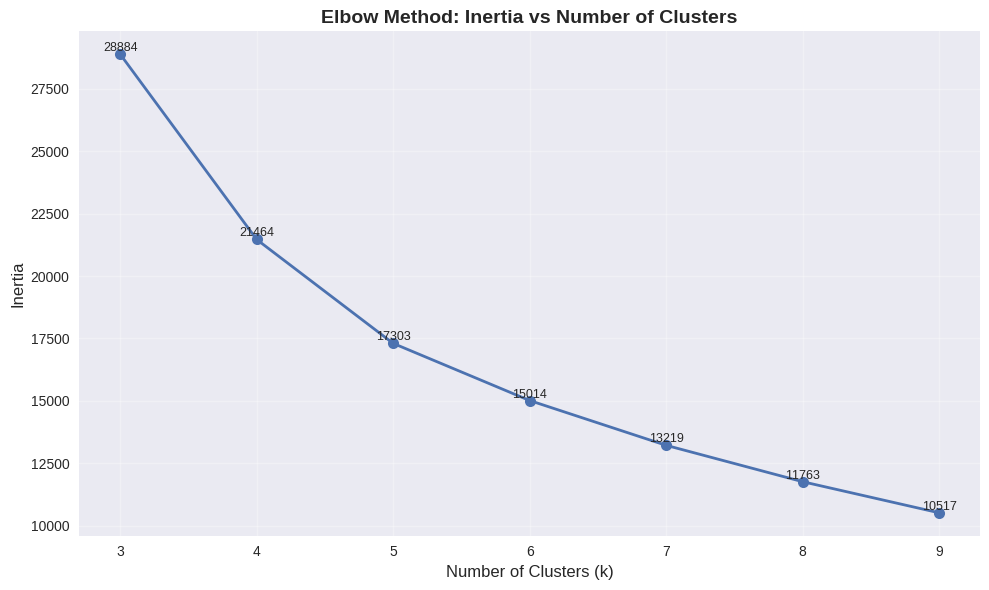

In [9]:
# 2.2 ANSWER: Create Elbow plot

# Create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method: Inertia vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

# Add value labels on each point
for i, (k, inertia) in enumerate(zip(k_range, inertia_values)):
    plt.text(k, inertia, f'{inertia:.0f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Based on the plot above, choose optimal k = 5


### 3: Cluster Analysis and Visualization [3 Marks]

#### 3.1 Identify the Cluster Number for Each Order

- Create a K-means model using the four numerical features from `all_orders_df` and the optimal number of clusters identified in Task 2.
- Fit the model on the scaled numerical features.
- Use the fitted model to assign a cluster number to each order and add a new column called `cluster` to `all_orders_df`.
- Show the first 10 rows of `all_orders_df` to verify cluster assignment.


In [10]:
optimal_k = 5

In [11]:
# 3.1 ANSWER: Fit K-means with optimal k and assign clusters

X_all = all_orders_df[numerical_features]

scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all)

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
all_orders_df['cluster'] = kmeans_final.fit_predict(X_all_scaled)

print(f"Cluster assignment complete. Added 'cluster' column to all_orders_df.")
print(f"\nFirst 10 rows:")
all_orders_df.head(10)


Cluster assignment complete. Added 'cluster' column to all_orders_df.

First 10 rows:


,order_id,basket_size,basket_qty,freight_ratio,product_diversity,top_product_category,payment_type,order_size_category,cluster
0,sdv-id-whzjUX,744.312535,1,0.092421,1.000000,construction_tools_construction,voucher,Small,1
1,sdv-id-dbopoJ,1556.667902,1,0.009889,1.000000,health_beauty,credit_card,Small,0
2,sdv-id-FSEOvM,62.060506,1,0.302145,1.000000,luggage_accessories,debit_card,Small,4
3,sdv-id-bQcBUR,73.873470,1,0.117375,1.000000,computers_accessories,credit_card,Small,1
4,sdv-id-MPxIXB,361.961537,3,0.095953,1.000000,pet_shop,voucher,Medium,1
5,sdv-id-ySodbB,867.750230,7,0.204442,0.857143,sports_leisure,voucher,Large,3
6,sdv-id-wdwBrk,55.965822,2,0.285101,0.500000,toys,points,Small,2
7,sdv-id-maBYtk,170.295452,3,0.089290,1.000000,computers_accessories,voucher,Medium,1
8,sdv-id-oodUXj,83.065603,1,0.236471,1.000000,furniture_decor,voucher,Small,4
9,sdv-id-zroJIL,98.250248,1,0.369709,1.000000,fashion_bags_accessories,points,Small,4


#### 3.2 Visualize the Clusters

Create two visualizations to understand your clusters:

- **Visualization 1: Cluster Profile Heatmap**
  - Visualize the cluster profiles using a heatmap to understand the average characteristics of each segment.
  - Step 1: Compute the mean of the four numerical features (`basket_size`, `basket_qty`, `freight_ratio`, `product_diversity`) for each cluster.
  - Step 2: Scale these means (e.g., using `StandardScaler` to calculate Z-scores) so that different units (price vs. count) can be compared directly.
  - Step 3: Plot the scaled means as a heatmap:
    - X-axis: Cluster number
    - Y-axis: Feature name
    - Color: Use a diverging colormap (e.g., `RdBu_r`) to distinguish features that are above average (positive Z-score) from those that are below average (negative Z-score)
    - Annotation: Display the Z-score values in each cell
  - Add a clear title.

- **Visualization 2: Cluster Size Distribution**
  - Create a bar chart showing the number of orders in each cluster.
    - X-axis: Cluster number (0, 1, 2, ...)
    - Y-axis: Count of orders
    - This helps you understand if clusters are balanced or if some clusters dominate.
  - Add a title and axis labels.


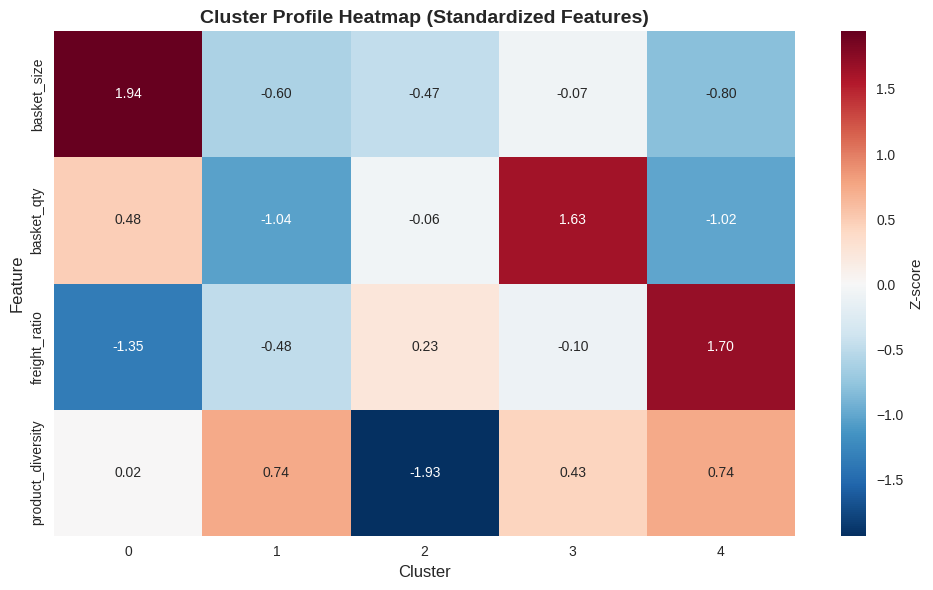

In [12]:
# 3.2 ANSWER: Visualization 1 - Cluster profile heatmap

cluster_means = all_orders_df.groupby('cluster')[numerical_features].mean()

scaler_heatmap = StandardScaler()
cluster_means_scaled = scaler_heatmap.fit_transform(cluster_means)
cluster_means_scaled_df = pd.DataFrame(
    cluster_means_scaled,
    index=cluster_means.index,
    columns=cluster_means.columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_means_scaled_df.T,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Z-score'}
)
plt.title('Cluster Profile Heatmap (Standardized Features)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


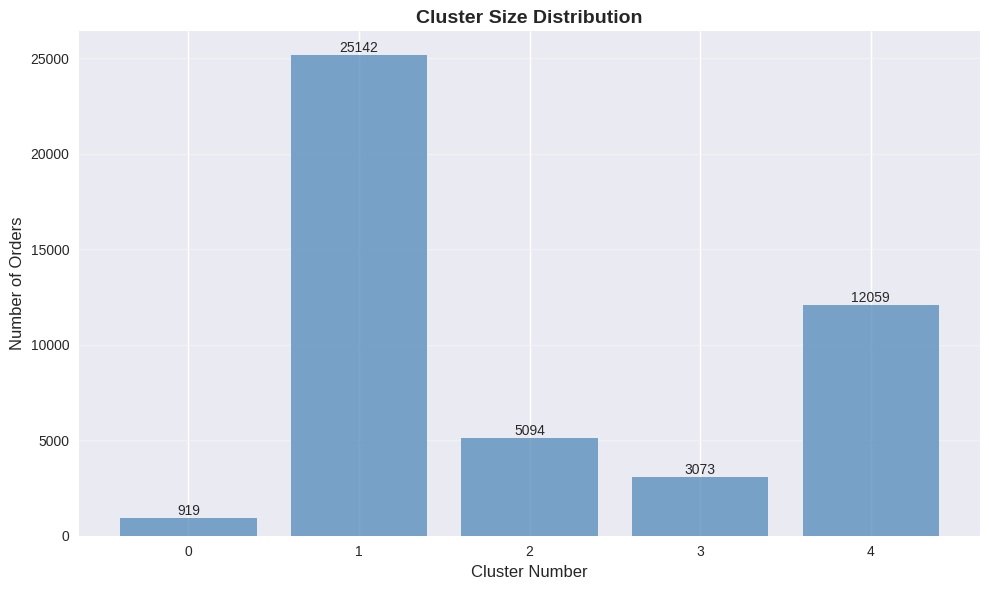

In [13]:
# 3.2 ANSWER: Visualization 2 - Cluster size distribution

cluster_counts = all_orders_df['cluster'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='steelblue', alpha=0.7)
plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Cluster Size Distribution', fontsize=14, fontweight='bold')
plt.xticks(cluster_counts.index)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(cluster_counts.values):
    plt.text(cluster_counts.index[i], v, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


**Briefly comment (2-3 sentences) on:**

- How well separated do the clusters appear based on the heatmap?
- Which features seem to have the most significant impact on defining the clusters? Why might this be the case?
- Based on the visualizations that you have generated, comment on the nature of the clusters and what it implies for an e-commerce business


**3.2 ANSWER:**

**Cluster Separation and Significant Features:**

The clusters demonstrate strong separation as indicated by the distinct Z-score profiles in the final heatmap. basket_size and freight_ratio appear to be the most significant drivers of cluster identity. For instance, Cluster 0 is uniquely defined by an exceptionally high basket_size (Z = 1.94), while Cluster 4 is characterized by a high freight_ratio (Z = 1.70). This suggests that order value and shipping cost structures are the primary variables differentiating purchasing behaviors.

**Nature of Clusters and Business Implications:**

The visualizations identify several actionable order segments:

- Cluster 0 (Premium Orders): High-value orders with very low freight ratios. These represent "VIP" transactions where the shipping cost is negligible compared to the basket value.

- Cluster 3 (High-Volume/Quantity): Orders with a high number of items (Z = 1.63).

- Cluster 4 (High Logistics Cost): Orders where freight represents a disproportionately high part of the value. For an e-commerce business, these insights imply the need for differentiated strategies, such as offering loyalty rewards for Cluster 0 and optimizing shipping bundles or setting higher free-shipping thresholds for Cluster 4 to improve profit margins.

**Cluster Size Distribution:**

The distribution shows that Cluster 1 is the dominant segment (25,142 orders), representing the "standard" or typical transaction for the platform. In contrast, Cluster 0 (919 orders) is a niche but high-value segment. Understanding this balance allows the business to allocate resources efficiently, focusing high-touch customer service on the premium minority while automating processes for the high-volume majority.


**Report — Market basket analysis (association rule mining):**  
We treat each order as a **transaction** of items (e.g. product category, payment type, size category). After encoding transactions into a binary matrix, we run the **Apriori** algorithm to find **frequent itemsets**, then derive **association rules** (antecedent → consequent) with support, confidence, and lift. _Business objective:_ Rules with high lift indicate which item combinations co-occur more than expected; these support cross-sell, bundling, and placement decisions.


### 4: Market Basket Analysis (Association Rule Mining) [8 Marks]

#### 4.1 Context: What is Market Basket Analysis?

Market Basket Analysis is an unsupervised learning technique that identifies which products, categories, or attributes are frequently observed together. In e-commerce, this helps answer questions such as:

- "Which payment methods are preferred for which product categories?"
- "Do certain order sizes correlate with specific product types?"
- "What are the multi-dimensional patterns across category, payment, and order size?"

Association rules are commonly described using three key metrics:

- **Support**: How frequently a pattern occurs (0-1 scale)
- **Confidence**: Likelihood of the consequent given the antecedent (0-1 scale)
- **Lift**: How much more likely the rule is compared to random chance (> 1 indicates a positive association)

The Apriori algorithm discovers frequent itemsets and then generates association rules from them.

In this task, you will perform Market Basket Analysis using the categorical features from `all_orders_df` to discover multi-dimensional associations between product category, payment type, and order size category.


#### 4.2 Prepare Transaction Data [1 Mark]

Convert each order in `all_orders_df` into a simple "basket" representation.

Create a Python list called `transactions`, where each element represents one order and contains exactly three string items constructed from that order:

- `cat_{top_product_category}` (e.g., `cat_electronics`, `cat_furniture_decor`)
- `pay_{payment_type}` (e.g., `pay_credit_card`, `pay_boleto`)
- `size_{order_size_category}` (e.g., `size_Small`, `size_Large`)

After constructing `transactions`, display the first 5 transactions to verify the format.


In [14]:
# 4.2 ANSWER: Create transaction list

transactions = []

for _, row in all_orders_df.iterrows():
    transaction = [
        f"cat_{row['top_product_category']}",
        f"pay_{row['payment_type']}",
        f"size_{row['order_size_category']}"
    ]
    transactions.append(transaction)

print(f"Total transactions: {len(transactions)}")
print(f"\nFirst 5 transactions:")
for i in range(5):
    print(f"Transaction {i+1}: {transactions[i]}")


Total transactions: 46287

First 5 transactions:
Transaction 1: ['cat_construction_tools_construction', 'pay_voucher', 'size_Small']
Transaction 2: ['cat_health_beauty', 'pay_credit_card', 'size_Small']
Transaction 3: ['cat_luggage_accessories', 'pay_debit_card', 'size_Small']
Transaction 4: ['cat_computers_accessories', 'pay_credit_card', 'size_Small']
Transaction 5: ['cat_pet_shop', 'pay_voucher', 'size_Medium']


#### 4.3 Encode Transactions and Apply Apriori Algorithm [2 Marks]

Use the `mlxtend` library to discover frequent itemsets and generate association rules.

- Step 1: Encode transactions using `TransactionEncoder` and display the shape of the encoded DataFrame.
- Step 2: Apply `apriori()` with `min_support = 0.01` and `use_colnames = True`, then display the number of frequent itemsets found.
- Step 3: Generate association rules using `association_rules()` with `metric = 'lift'` and `min_threshold = 1.0`, then display the number of rules generated.


In [15]:
# 4.3 ANSWER: Step 1 - Encode transactions

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transactions_df = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded transactions shape: {transactions_df.shape}")
print(f"Number of unique items: {transactions_df.shape[1]}")
print(f"\nFirst 5 rows of encoded transactions:")
transactions_df.head()


Encoded transactions shape: (46287, 79)
Number of unique items: 79

First 5 rows of encoded transactions:


,cat_agro_industry_and_commerce,cat_air_conditioning,cat_art,cat_arts_and_craftmanship,cat_audio,cat_auto,cat_baby,cat_bed_bath_table,cat_books_general_interest,cat_books_imported,...,cat_toys,cat_watches_gifts,pay_credit_card,pay_debit_card,pay_not_defined,pay_points,pay_voucher,size_Large,size_Medium,size_Small
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [16]:
# 4.3 ANSWER: Step 2 - Apply Apriori

frequent_itemsets = apriori(transactions_df, min_support=0.01, use_colnames=True)

print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
print(f"\nTop 10 frequent itemsets by support:")

frequent_itemsets.sort_values('support', ascending=False).head(10)

Number of frequent itemsets found: 102

Top 10 frequent itemsets by support:


,support,itemsets
26,0.864735,(size_Small)
20,0.604641,(pay_credit_card)
75,0.528118,"(size_Small, pay_credit_card)"
23,0.298399,(pay_voucher)
80,0.250805,"(size_Small, pay_voucher)"
2,0.138678,(cat_bed_bath_table)
34,0.111349,"(size_Small, cat_bed_bath_table)"
25,0.098149,(size_Medium)
31,0.097695,"(pay_credit_card, cat_bed_bath_table)"
11,0.090911,(cat_health_beauty)


**Report — Interpreting association rules:**  
We sort rules by lift (or confidence) and display the top rules. **Lift > 1** means the consequent appears more often with the antecedent than in general; **lift > 1.5** is often treated as a strong association. The top patterns (as in 4.5) summarize which categories, payment types, or sizes tend to co-occur—directly informing promotions and product placement.


In [17]:
# 4.3 ANSWER: Step 3 - Generate association rules

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

print(f"Number of association rules generated: {len(rules)}")
print(f"\nSample of rules:")
rules.head()


Number of association rules generated: 138

Sample of rules:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(pay_credit_card),(cat_auto),0.604641,0.030592,0.020503,0.033909,1.108423,1.0,0.002006,1.003433,0.247414,0.033352,0.003422,0.352053
1,(cat_auto),(pay_credit_card),0.030592,0.604641,0.020503,0.670198,1.108423,1.0,0.002006,1.198777,0.100904,0.033352,0.165817,0.352053
2,(pay_credit_card),(cat_baby),0.604641,0.023592,0.015015,0.024833,1.052604,1.0,0.000750,1.001273,0.126403,0.024486,0.001271,0.330640
3,(cat_baby),(pay_credit_card),0.023592,0.604641,0.015015,0.636447,1.052604,1.0,0.000750,1.087487,0.051182,0.024486,0.080449,0.330640
4,(size_Small),(cat_baby),0.864735,0.023592,0.020913,0.024184,1.025108,1.0,0.000512,1.000607,0.181074,0.024110,0.000607,0.455316


#### 4.4 Extract and Display Top 10 Rules [1 Mark]

Sort the association rules by **lift** in descending order and display the top 10 rules in a table showing:

- Antecedents (left-hand side of rule)
- Consequents (right-hand side of rule)
- Support
- Confidence
- Lift

Example rule output and interpretation:

| antecedents                       | consequents       | support | confidence | lift |
| :-------------------------------- | :---------------- | :------ | :--------- | :--- |
| (cat_furniture_decor, size_Large) | (pay_credit_card) | 0.042   | 0.756      | 1.84 |

"Customers who purchase **furniture** in **large orders** have a **75.6% probability** (confidence) of paying with a **credit card**. This behavior is **1.84 times more likely** (lift) than the general probability of using a credit card.


In [ ]:
# 4.4 ANSWER: Display top 10 rules by lift

top_rules = rules.sort_values('lift', ascending=False).head(10)

top_rules_display = top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()

print("Top 10 Association Rules by Lift:")
print("="*80)
top_rules_display


Top 10 Association Rules by Lift:


,antecedents,consequents,support,confidence,lift
24,(size_Large),(cat_furniture_decor),0.014583,0.392899,5.328480
25,(cat_furniture_decor),(size_Large),0.014583,0.197773,5.328480
73,"(pay_credit_card, size_Medium)",(cat_bed_bath_table),0.016851,0.280576,2.023212
76,(cat_bed_bath_table),"(pay_credit_card, size_Medium)",0.016851,0.121514,2.023212
77,(size_Medium),"(pay_credit_card, cat_bed_bath_table)",0.016851,0.171693,1.757439
72,"(pay_credit_card, cat_bed_bath_table)",(size_Medium),0.016851,0.172490,1.757439
27,(size_Medium),(cat_furniture_decor),0.012660,0.128990,1.749354
26,(cat_furniture_decor),(size_Medium),0.012660,0.171696,1.749354
8,(cat_bed_bath_table),(size_Medium),0.022749,0.164044,1.671388
9,(size_Medium),(cat_bed_bath_table),0.022749,0.231785,1.671388


#### 4.5 Interpretation (3-4 sentences) [3 Marks]

Write a brief interpretation explaining:

- What the top 3 unique rules tell you about customer behavior
- Which combinations are most strongly associated (highest lift)
- Why these associations might exist (business intuition)
- Change the min_support value to 0.005 and 0.3 and comment on any changes in the rules identified


**4.5 ANSWER:**

The top 3 unique association patterns reveal distinct purchasing behaviors: (1) Large orders strongly associate with furniture(2) Medium-sized orders with credit card payments associate with bed/bath/table products. (3) Medium orders generally associate with furniture.

The strongest association is the furniture-large order combination with a lift of 5.33, which is exceptionally high and indicates furniture is 5.3 times more likely to appear in large orders than random chance.

This makes business sense because furniture items are inherently expensive and bulky, requiring significant shipping costs that inflate order values. The second-tier associations (lift ~1.7-2.0) involving bed/bath products and medium orders reflect household shopping patterns where customers bundle related items.

When changing min_support to 0.005 (lower threshold), the algorithm would discover more granular, niche associations including rare product combinations and specific category pairs, potentially revealing specialized customer segments but with lower statistical reliability. Conversely, setting min_support to 0.3 (higher threshold) would only capture the most common universal patterns like "credit_card + Small order" combinations, eliminating all category-specific insights shown above, as even the most frequent product category (bed_bath_table at 13.9% support) wouldn't meet this threshold. This demonstrates the trade-off between discovering actionable niche patterns versus focusing only on mass-market behaviors.


#### 4.6 Business Recommendations (2-3 bullet points) [1 Mark]

Based on the discovered associations, provide actionable business recommendations for an e-commerce firm.


**4.6 ANSWER:**

_[Write your business recommendations here as bullet points]_

- **Implement furniture-focused upselling and cross-selling strategies**: Since large orders strongly correlate with furniture purchases (lift=5.33), create targeted product bundles that combine furniture with complementary items.

- **Optimize payment options and promotions for medium-value home essential purchases**: Given the strong association between credit card payments and medium-sized bed/bath/table orders (lift=2.02), partner with credit card companies to offer installment plans or bonus rewards points specifically for home essentials categories.

- **Develop category-specific inventory and logistics planning**: Use the discovered associations to optimize warehouse placement and shipping strategies—prioritize furniture stock in distribution centers with robust large-item handling capacity, while ensuring bed/bath inventory is readily available for medium-quantity orders.


**Summary:** The steps and reasoning for the full pipeline are described in the **Report** notes placed inline above: **Assignment 1** (data loading, joining, missing values, invalid records, sanity checks, new features, storage, EDA); **Assignment 2** (data preparation, train/test split, categorical encoding, scaling, model training, evaluation and selection); **Assignment 3** (all_orders_df / orders_analysis_df, elbow method and K-Means clustering, market basket preparation, Apriori, association rules and interpretation).


#### Tips

- Rules with **lift > 1.5** are considered strong associations; rules with **lift > 2.0** are very strong.
- When writing interpretations, explain not just the statistical strength but also the **business logic** behind the patterns.


---

## Task: Report (5 Marks)

### Objective

(Note: No separate report submission is required.) The report comprises the write-up that you have been working on within this iPython notebook. The write-up/report should clearly describe the steps performed and the reasoning behind each processing done for all the tasks from Assignment 1 until Association mining above.

### 1: Write-up / Report

Describe the steps performed and the reasoning behind each processing step for all tasks you have worked on so far:

- Assignment 1 (data cleaning and preprocessing)
- Assignment 2 (supervised learning)
- Assignment 3 (unsupervised learning)

Include your explanations inline near the cells where processing is done, and keep your descriptions concise but clear. Connect each analysis step to business objectives where appropriate.


---

### 2: Publish the Report

Publish the report as a read-only github.io static page.

- Note: this differs from setting up a GitHub repository with your iPython notebook in it.
- Convert your notebook to HTML and host it on GitHub Pages (e.g., using nbconvert or Jupyter Book).

Ensure the page is publicly accessible and provide the URL in your Canvas submission.

**Your published URL:**

*https://vern-h.github.io/it5100f-report/*


---

# End of Assignment 3

**Before submission, ensure:**

1. All code cells execute without errors
2. All markdown cells contain your written explanations
3. Visualizations are clear and properly labeled
4. Your notebook tells a coherent story from start to finish
5. Your github.io page is published and URL is provided

**Good luck!**
